In [159]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import acquire
from scipy import stats
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

np.random.seed(123)

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date

In [160]:
# Pasting a code I found from itertools documentation.

def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

In [161]:
zillow = acquire.get_zillow_data()

In [162]:
# Get a peek of the dataframe
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77574 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

In [163]:
# Create a function that will remove rows and columns that have missing values past a certain threshold.
def handle_missing_values(df, p_row = 0.84, p_col = 0.84):
    ''' function which takes in a dataframe, required notnull proportions of non-null rows and columns.
    drop the columns and rows columns based on theshold:'''
    
    #drop columns with nulls
    threshold = int(p_col * len(df.index)) # Require that many non-NA values.
    df.dropna(axis = 1, thresh = threshold, inplace = True)
    
    #drop rows with nulls
    threshold = int(p_row * len(df.columns)) # Require that many non-NA values.
    df.dropna(axis = 0, thresh = threshold, inplace = True)
    
    
    return df

In [164]:
b = handle_missing_values(zillow)

In [165]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77474 entries, 0 to 77573
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77474 non-null  int64  
 1   parcelid                      77474 non-null  int64  
 2   bathroomcnt                   77474 non-null  float64
 3   bedroomcnt                    77474 non-null  float64
 4   calculatedbathnbr             76959 non-null  float64
 5   calculatedfinishedsquarefeet  77373 non-null  float64
 6   finishedsquarefeet12          73919 non-null  float64
 7   fips                          77474 non-null  float64
 8   fullbathcnt                   76959 non-null  float64
 9   latitude                      77474 non-null  float64
 10  longitude                     77474 non-null  float64
 11  lotsizesquarefeet             69300 non-null  float64
 12  propertycountylandusecode     77474 non-null  object 
 13  p

In [166]:
# Remove observations where bedroom and bathroom counts are zero.
b = b[b.bedroomcnt != 0]
b = b[b.bathroomcnt !=0]

In [167]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76720 entries, 0 to 77573
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            76720 non-null  int64  
 1   parcelid                      76720 non-null  int64  
 2   bathroomcnt                   76720 non-null  float64
 3   bedroomcnt                    76720 non-null  float64
 4   calculatedbathnbr             76703 non-null  float64
 5   calculatedfinishedsquarefeet  76709 non-null  float64
 6   finishedsquarefeet12          73560 non-null  float64
 7   fips                          76720 non-null  float64
 8   fullbathcnt                   76703 non-null  float64
 9   latitude                      76720 non-null  float64
 10  longitude                     76720 non-null  float64
 11  lotsizesquarefeet             68569 non-null  float64
 12  propertycountylandusecode     76720 non-null  object 
 13  p

In [168]:
# Take a look at the amount of missing values.
b.isnull().sum()

id                                 0
parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                 17
calculatedfinishedsquarefeet      11
finishedsquarefeet12            3160
fips                               0
fullbathcnt                       17
latitude                           0
longitude                          0
lotsizesquarefeet               8151
propertycountylandusecode          0
propertylandusetypeid              0
rawcensustractandblock             0
regionidcity                    1447
regionidcounty                     0
regionidzip                       44
roomcnt                            0
yearbuilt                         65
structuretaxvaluedollarcnt        87
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
censustractandblock              223
logerror                           0
t

In [169]:
# Create a list of columns to drop.
columns_to_drop = ['calculatedbathnbr','finishedsquarefeet12','id','transactiondate','parcelid','fullbathcnt','propertycountylandusecode','propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty','regionidzip','censustractandblock','propertylandusedesc']

In [170]:
# Create a function that will drop unwanted columns.
def drop_columns(df, drop_col):
    df = df.drop(columns=drop_col)
    return df

In [171]:
b = drop_columns(b, columns_to_drop)

In [172]:
# use KNN imputer to fill missing values. 
from sklearn.impute import KNNImputer

# Quantitative columns used for imputation.
X_quant = b[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt','taxvaluedollarcnt', 'landtaxvaluedollarcnt']]

# Define the imputer.
imputer = KNNImputer(n_neighbors=10)

# Fit the imputer on the train dataset. This method will transform it as well.
b_imputed = imputer.fit_transform(X_quant)

In [173]:
# Convert imputed array to a dataframe
b_imputed = pd.DataFrame(b_imputed, index = b.index)
#b_imputed.head()

# Assign imputed values to the original columns.
b[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] = b_imputed



In [174]:
# Change yearbuilt to age

In [175]:
def yearbuilt_years(df):
    df.yearbuilt =  df.yearbuilt.astype(int)
    year = date.today().year
    df['age'] = year - df.yearbuilt
    # dropping the 'yearbuilt' column now that i have the age
    df = df.drop(columns=['yearbuilt'])
    return df

In [176]:
b = yearbuilt_years(b)

# New features created

In [178]:
# Create new features here
b['acres']= b.lotsizesquarefeet/43560


# ratio of bathrooms to bedrooms
b['bed_bath_ratio'] = b.bedroomcnt / b.bathroomcnt

# bin from brent
#b['age_bins'] = pd.cut(b.age, 10, labels=False)


# bin acres
b['acres_bin'] = pd.cut(b.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                    labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])
    

b['land_dollar_per_sqft'] = b.landtaxvaluedollarcnt/b.lotsizesquarefeet

b['lot_dollar_sqft_bin'] = pd.cut(b.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )
b = b.astype({'acres_bin': float,  'lot_dollar_sqft_bin' : float})  #'age_bins': float,

In [179]:
b = b.dropna()

In [151]:
b.isna().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
roomcnt                         0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
age                             0
acres                           0
bed_bath_ratio                  0
age_bins                        0
acres_bin                       0
land_dollar_per_sqft            0
lot_dollar_sqft_bin             0
dtype: int64

### There are a few more columns with missing values that I will impute after I split.

In [180]:
# split test off, 20% of original df size. 
train_validate, test = train_test_split(b, test_size=.2, 
                                        random_state=42)

# split validate off, 30% of what remains (24% of original df size)
# thus train will be 56% of original df size. 
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=42)

print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (42959, 20)
validate observations:  (18412, 20)
test observations:  (15343, 20)


In [74]:
train.isnull().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
roomcnt                         0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
age                             0
acres                           0
bed_bath_ratio                  0
age_bins                        0
acres_bin                       0
land_dollar_per_sqft            0
lot_dollar_sqft_bin             0
dtype: int64

# Takeaway
* Initially I thought logerror would vary noticeably depending on the latitude and longitude. But, the logerror seems to be uniform all throughout the landscape.
* Maybe if I bin logerror I can get a better visualization.

In [31]:
# Create a bunch of bins for logerror to see if it will help with visualzing logerror when plotted on top of longitude vs latitude
train['logerror_bin'] = pd.cut(train.logerror, bins=np.arange(train.logerror.min(),train.logerror.max(),step=1.5))

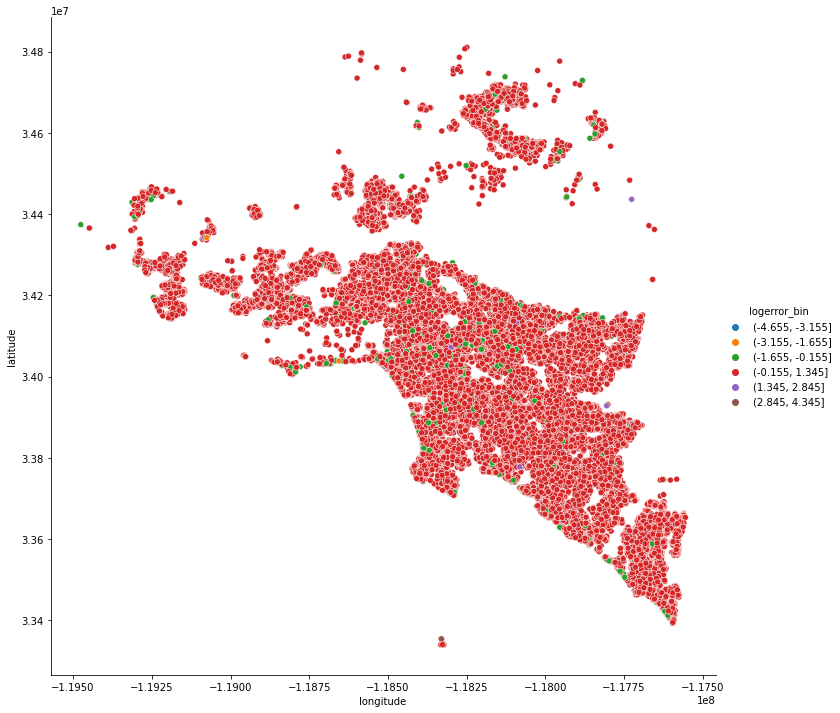

In [32]:
sns.relplot(train.longitude, train.latitude, hue=train.logerror_bin, height=10)

# Takeaways
* Binning the logerror made some of the observations stand out a little more, but I can't see any patterns as of now.
* Just call me Dora because I am about to...

### Explore!

### Target Variable: logerror
#### What will all our features look like plotted against the target (and everything else)?

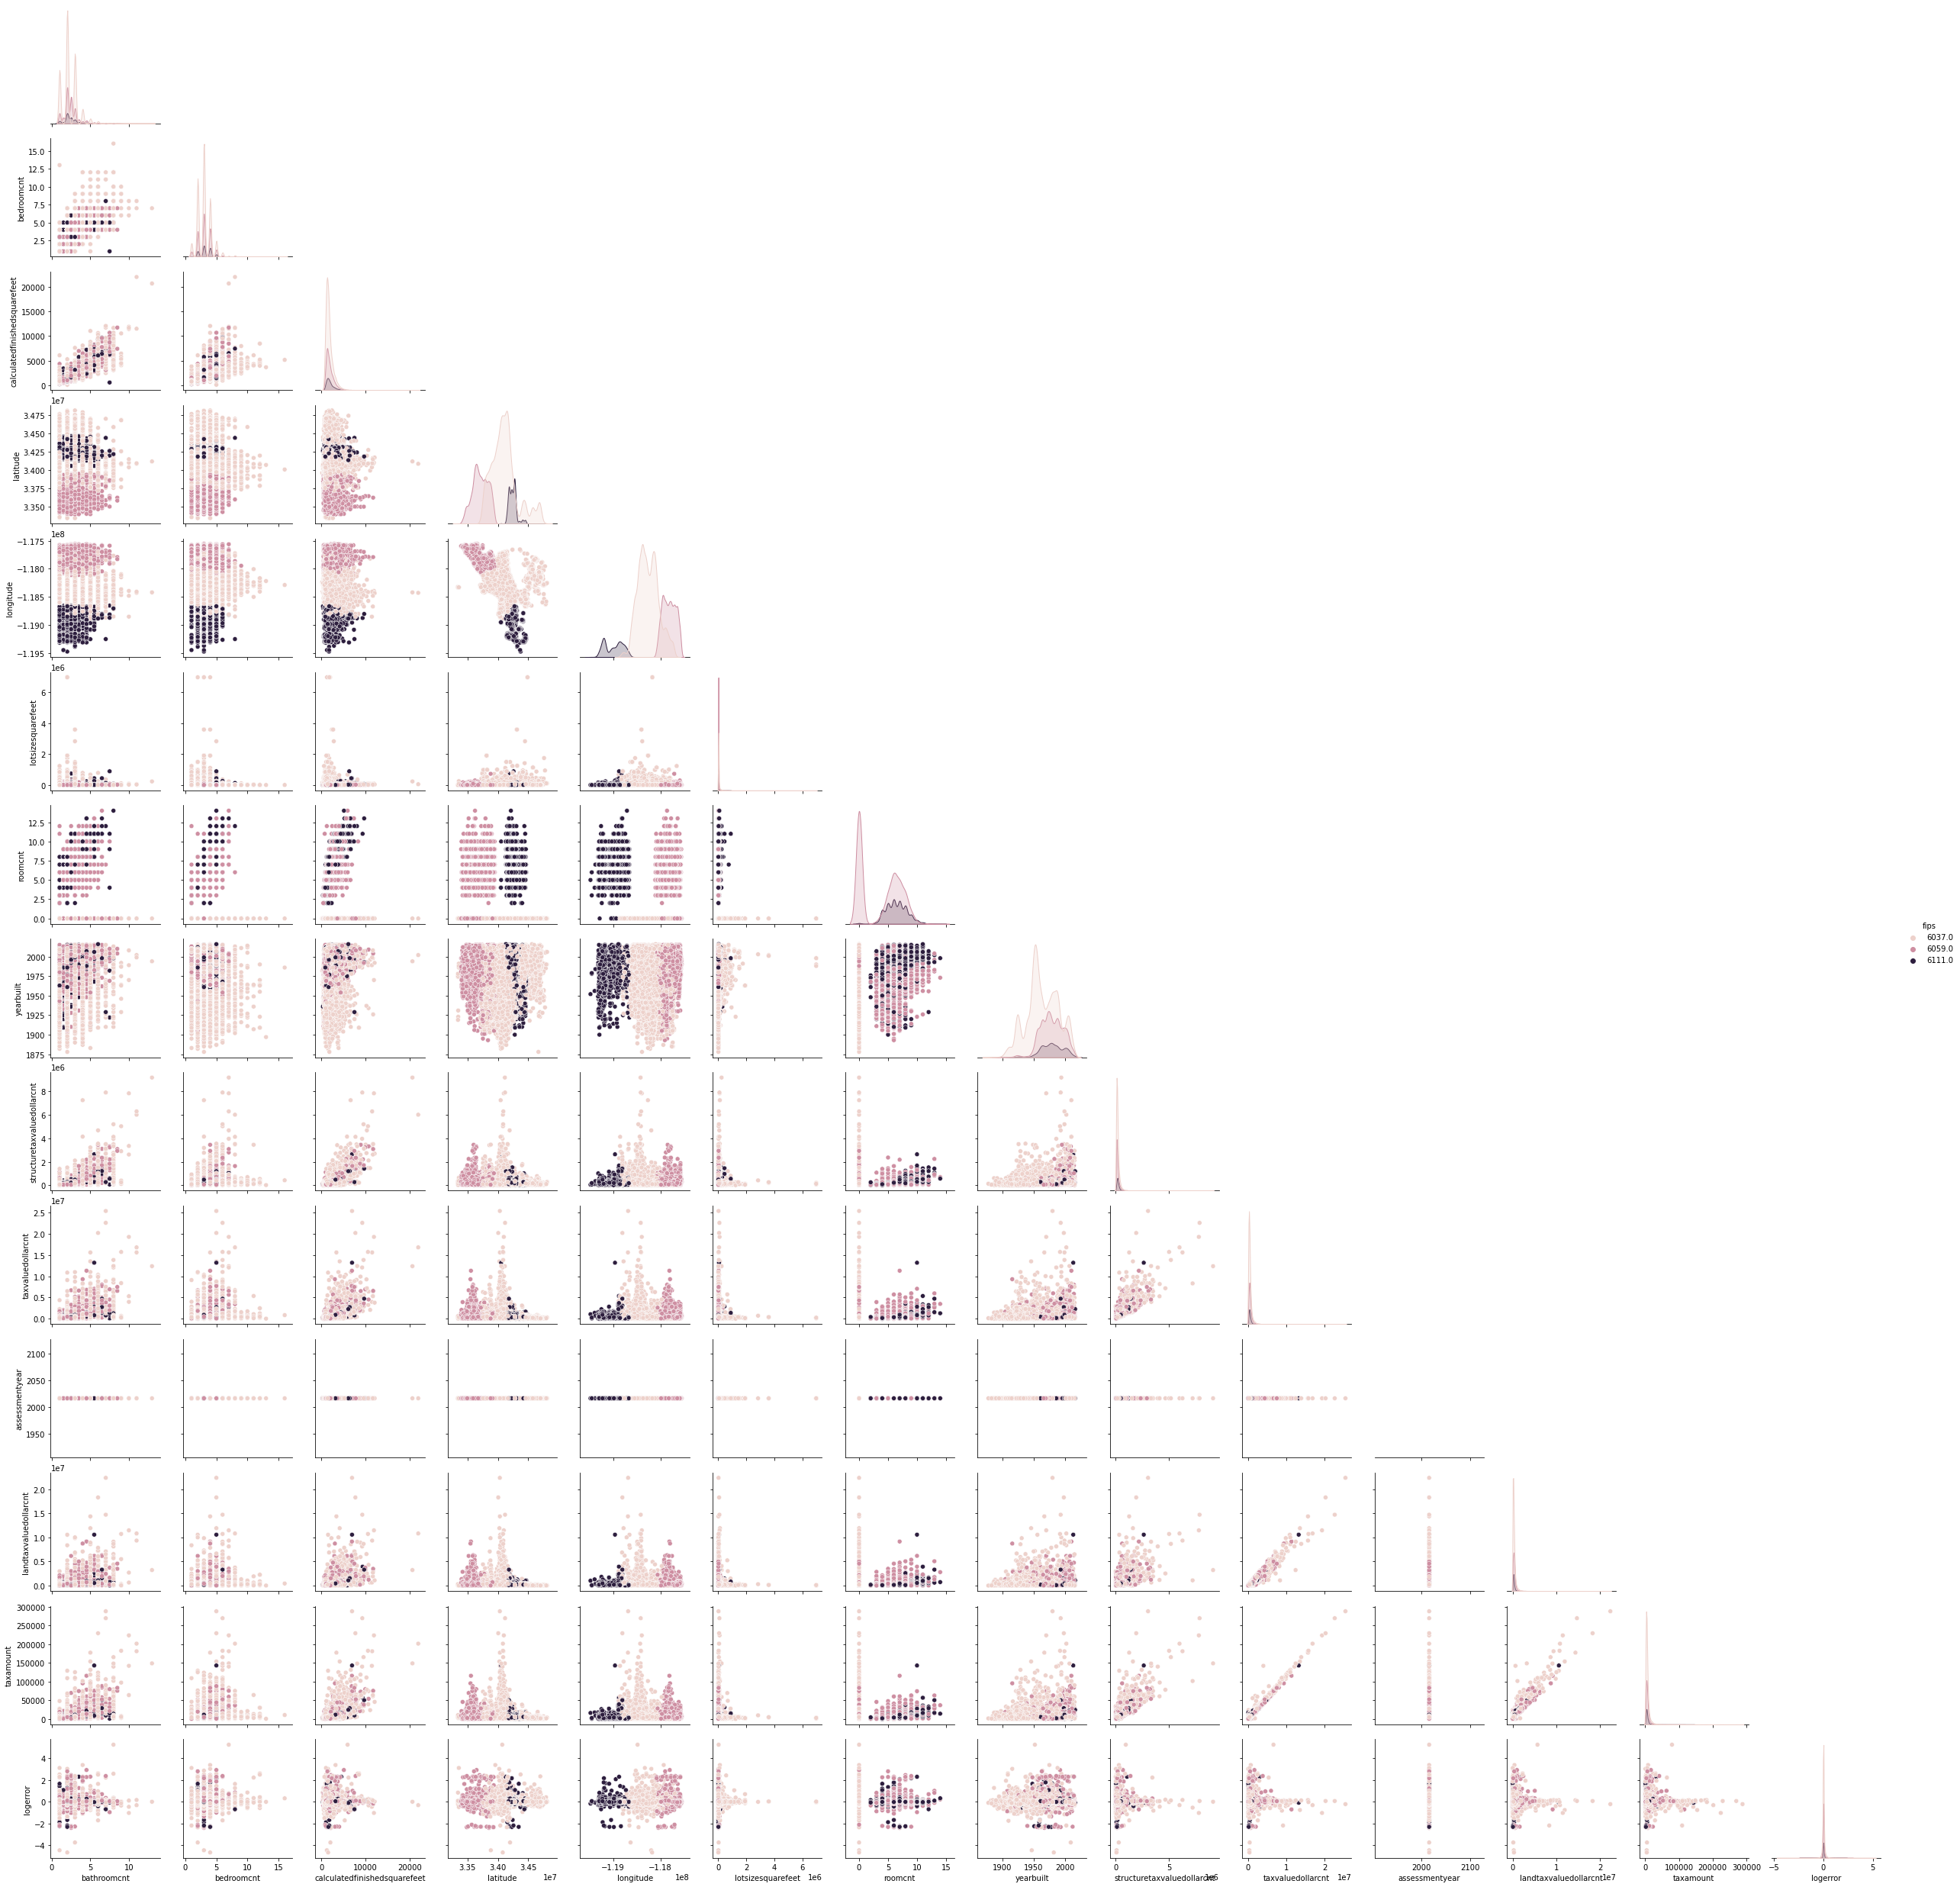

In [33]:
sns.pairplot(train, corner=True, hue='fips')

*** Create a function that will remove the target, iterate through a list of independent variables creating a list of the maximum combination of triplets.
-> Use the rfe_regressor to get the top 4 triplets that drives logerror

Text(0.5, 0, 'land_area')

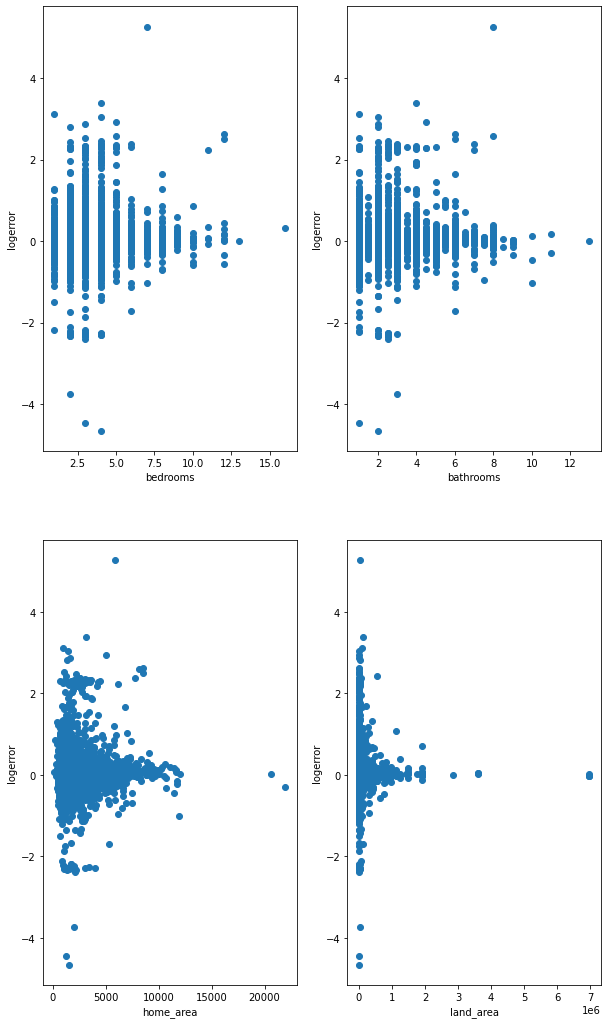

In [34]:
plt.figure(figsize=(10, 18))

plt.subplot(221)
plt.scatter(train.bedroomcnt, train.logerror)
plt.ylabel('logerror')
plt.xlabel('bedrooms')

plt.subplot(222)
plt.scatter(train.bathroomcnt, train.logerror)
plt.ylabel('logerror')
plt.xlabel('bathrooms')

plt.subplot(223)
plt.scatter(train.calculatedfinishedsquarefeet, train.logerror)
plt.ylabel('logerror')
plt.xlabel('home_area')

plt.subplot(224)
plt.scatter(train.lotsizesquarefeet, train.logerror)
plt.ylabel('logerror')
plt.xlabel('land_area')

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42959 entries, 41278 to 72921
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   42959 non-null  float64
 1   bedroomcnt                    42959 non-null  float64
 2   calculatedfinishedsquarefeet  42959 non-null  float64
 3   fips                          42959 non-null  float64
 4   latitude                      42959 non-null  float64
 5   longitude                     42959 non-null  float64
 6   lotsizesquarefeet             42959 non-null  float64
 7   roomcnt                       42959 non-null  float64
 8   structuretaxvaluedollarcnt    42959 non-null  float64
 9   taxvaluedollarcnt             42959 non-null  float64
 10  assessmentyear                42959 non-null  float64
 11  landtaxvaluedollarcnt         42959 non-null  float64
 12  taxamount                     42959 non-null  float64
 1

# Takeaways

* There doesn't seem to be any linear trend when plotting the independent variable against our target.
* There is a large variance in logerror among the lower end of the sepctrum across all variables.
* Small land area seems to have higher logerror.

## 1)Does age effect the logerror?

In [158]:
train.age_bins.value_counts()

2.0    11307
1.0    10700
3.0    10316
0.0     5996
4.0     3749
5.0      853
6.0       37
7.0        1
Name: age_bins, dtype: int64

In [182]:
train['age_bins'] = pd.cut(train.age, 10, labels=False)
#X_train['age_bins'] = pd.cut(train.yearbuilt, 10, labels=False)
#X_train_scaled['age_bins'] = pd.cut(train.yearbuilt, 10, labels=False)

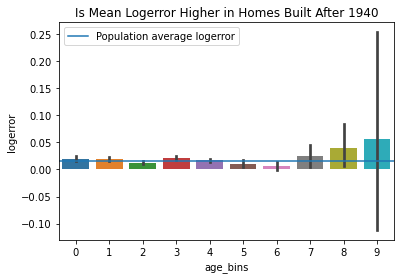

In [183]:
plt.title("Is Mean Logerror Higher in Homes Built After 1940")
sns.barplot(x="age_bins", y="logerror", data=train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean, label="Population average logerror")
plt.legend()
plt.show()

In [184]:
older_homes_logerror = train[train.age_bins <= 4].logerror
newer_homes_logerror = train[train.age_bins >= 5].logerror

### $H_0$: There is no difference in mean logerror between older homes and newer homes.
### $H_a$: There is a difference in mean logerror between older homes and newer homes.

In [185]:
# Check for equal variances.
# A stats Levene test - returns p value. small p-value means unequal variances.
t, p = stats.levene(older_homes_logerror, newer_homes_logerror)
# high p-value suggests that the populations have equal variances.

if p < alpha:
    print(f'p-value: {p}. There is unequal variance.')

p-value: 5.077633153002707e-88. There is unequal variance.


In [186]:
alpha = 0.05
# Run a Independent T-Test to test for a difference in mean logerror between newer homes and older homes.
t, p = stats.ttest_ind(older_homes_logerror, newer_homes_logerror, equal_var=False)
if p < alpha:
    print(f'p-value: {p}. We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

p-value: 0.04991037355968358. We reject the null hypothesis.


# Takeaway
* The mean logerror for newer homes seems to be greater than the mean logerror for older homes.

## 2) Does the mean logerror differ among the three counties?

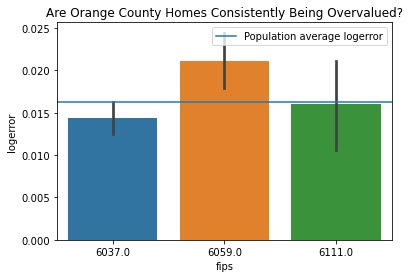

In [187]:
plt.title("Are Orange County Homes Consistently Being Overvalued?")
sns.barplot(x="fips", y="logerror", data=train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean, label="Population average logerror")
plt.legend()
plt.show()

# Takeaway
* The mean logerror of Orange County seems to be significantly higher than the population average.
* The mean logerror of Ventura County seems slightly higher than the population average.
* The mean logerror of LA County seems slightly lower than the population average.

In [188]:
# Create a dataframe for each county.
LA_county = train[train['fips']== 6037]
Ventura_county = train[train['fips']== 6111]
Orange_county = train[train['fips']== 6059]

# Create list of counties to make looping easier.
county_list = [LA_county, Ventura_county, Orange_county]

# Verify shape of new dataframes.
LA_county.shape, Ventura_county.shape, Orange_county.shape

# Create variables that hold the logerror values for each county.
LA_logerror = LA_county['logerror']
Ventura_logerror = Ventura_county['logerror']
Orange_logerror = Orange_county['logerror']

#### $H_0$: The mean logerror of Orange County is equal to the mean logerror of Ventura County.
#### $H_a$: The mean logerror of Orange County is greater than the mean logerror of Ventura County.

In [189]:
# A stats Levene test - returns p value. small p-value means unequal variances
print(stats.levene(LA_logerror, Ventura_logerror))
print(stats.levene(LA_logerror, Orange_logerror))
print(stats.levene(Ventura_logerror, Orange_logerror))
# high p-value suggests that the populations have equal variances

LeveneResult(statistic=16.608706183051446, pvalue=4.605171846058299e-05)
LeveneResult(statistic=38.81116906594106, pvalue=4.715476723939842e-10)
LeveneResult(statistic=0.0015335417366291626, pvalue=0.9687629854769042)


# Takeaway
* There are equal variances between LA County logerror and both Ventura County and Orange County logerror.
* There is an unqual variance between Ventura County logerror and Orange County logerror.
* I will set the equal_var argument to False for the Ventura_vs_Orange Independent T-Test.

In [190]:
alpha = 0.5
# Use a Kruskal-Wallis test to test for equality in mean logerror between the three counties.
t, p = stats.kruskal(LA_logerror, Ventura_logerror, Orange_logerror)
print(f'p-value: {p}')
if p < alpha:
    print("We reject the null hypothesis that the mean logerror of the three counties are equal.")
else:
    pinrt("We fail to reject the null hypothesis.")

p-value: 0.0003910922482866329
We reject the null hypothesis that the mean logerror of the three counties are equal.


# Takeaway
* There is a difference between the three counties in mean logerror. I will create dummy variables for the counties and use them as a features in my model. 

In [191]:
# Create dummy variables for the counties.
def get_counties(df):
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    return df_dummies

In [192]:
train = get_counties(train)
validate = get_counties(validate)
test = get_counties(test)

## 3)Does tax value effect the logerror?

<Figure size 1152x576 with 0 Axes>

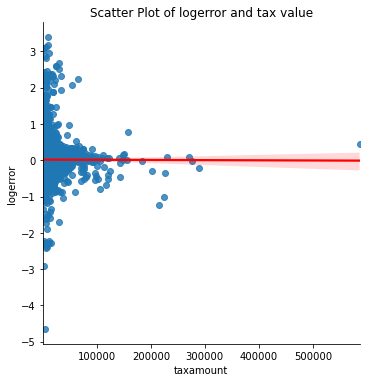

In [193]:
plt.figure(figsize=(16,8))
sns.lmplot(data = train, x = 'taxamount', y = 'logerror',line_kws={'color': 'red'})
plt.title("Scatter Plot of logerror and tax value")
plt.show()

### Takeaway
* We see no trend, so lets run a pearsons R test

#### H0: There is not linear correlation between the tax value and the logerror.

#### HA: There is linear correlation between the tax value and the logerror.

In [194]:
test_results = stats.pearsonr(train.logerror, train.taxamount)
r, p = test_results
print("r: ", r, "p: ", p)

r:  -0.002286349081902227 p:  0.6355939078938395


### Takeaway there is not linear correlation with this low P-value

## 4)Does area effect the logerror?

<Figure size 1152x576 with 0 Axes>

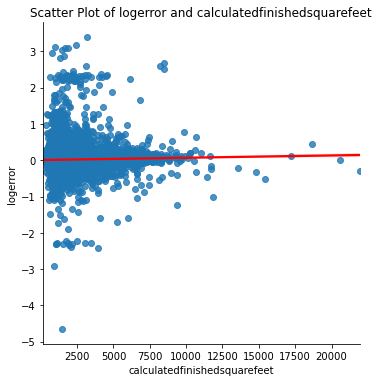

In [121]:
plt.figure(figsize=(16,8))
sns.lmplot(data = train, x = 'calculatedfinishedsquarefeet', y = 'logerror',line_kws={'color': 'red'})
plt.title("Scatter Plot of logerror and calculatedfinishedsquarefeet")
plt.show()

#### H0: There is not linear correlation between the area and the logerror.

#### HA: There is linear correlation between the area and the logerror.

In [122]:
test_results = stats.pearsonr(train.logerror, train.calculatedfinishedsquarefeet)
r, p = test_results
print("r: ", r, "p: ", p)

r:  0.036401193380460134 p:  4.4541871632099807e-14


### Takeaways
* There is a linear correlation between the area and logerror!

### Scale the data

In [36]:
# Create a scaler object using the MinMaxScaler
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit the scaler on the train dataset
# Use the select_dtypes to avoid an error when it tries to fit on the datetime datatype
scaler.fit(train.select_dtypes(include='float'))

# Use the scaler to transform the datasets
# Use the select_dtypes to avoid an error when it tries to transform on the datetime datatype
train_scaled = scaler.transform(train.select_dtypes(include='float'))
validate_scaled = scaler.transform(validate.select_dtypes(include='float'))
test_scaled = scaler.transform(test.select_dtypes(include='float'))

## Separate the target from the independent variables.

In [112]:
X_train = train.drop(columns='logerror')# , 'logerror_bin'
X_validate = validate.drop(columns='logerror')
X_test = test.drop(columns='logerror')

In [113]:
def Min_Max_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs 
    """
    scaler = sklearn.preprocessing.MinMaxScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [114]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [115]:
y_train = train[['logerror']]
y_validate = validate[['logerror']]
y_test = test[['logerror']]

### Choose top five features

In [116]:
# Set the number of top features to present
k = 5

# Let's start with Select K Best
# Make the thing
kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k=5)

# fit the thing
kbest.fit(X_train, y_train)

# use the thing, 
# get_support() produces an array of booleans, so we can filter out the column names that matter the most
kbest_features = X_train.columns[kbest.get_support()].tolist()

print("KBest's 5 best features are", kbest_features)

KBest's 5 best features are ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'longitude', 'roomcnt']


In [119]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=5)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [120]:
rfe_feature

['calculatedfinishedsquarefeet',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount']

### Set the baseline model

In [44]:
# 1. Predict logerror mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

RMSE using Mean
Train/In-Sample:  0.16981 
Validate/Out-of-Sample:  0.16668
RMSE using Median
Train/In-Sample:  0.17005 
Validate/Out-of-Sample:  0.16713


### Try using a linear regression model (OLS)

In [45]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column since we added additional columns to y_train.
lm.fit(X_train[rfe_feature], y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train[rfe_feature])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate[rfe_feature])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1694753384800109 
Validation/Out-of-Sample:  0.1664740601937647


### Try using a LassoLars model

In [46]:
# create the model object
lars = LassoLars(alpha=1.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train[rfe_feature], y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train[rfe_feature])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate[rfe_feature])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.16981225147598503 
Validation/Out-of-Sample:  0.16668326891953264


In [47]:
y_train.head(-10)

,logerror,logerror_pred_mean,logerror_pred_median,logerror_pred_lm,logerror_pred_lars
45257,-0.307749,0.015392,0.006411,0.007959,0.015392
54021,-0.123643,0.015392,0.006411,0.002773,0.015392
71314,-0.002535,0.015392,0.006411,0.001414,0.015392
8173,-0.045101,0.015392,0.006411,0.011557,0.015392
20821,0.014981,0.015392,0.006411,0.001219,0.015392
...,...,...,...,...,...
9369,0.073176,0.015392,0.006411,0.009446,0.015392
66274,0.440944,0.015392,0.006411,0.017604,0.015392
33161,-0.053477,0.015392,0.006411,0.004164,0.015392
43073,-0.039885,0.015392,0.006411,0.013246,0.015392


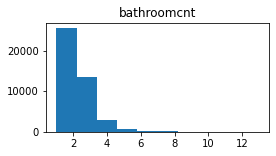

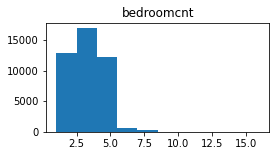

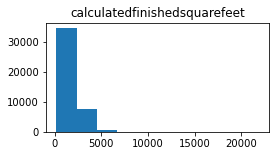

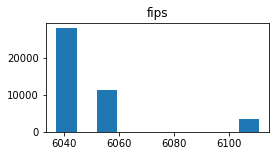

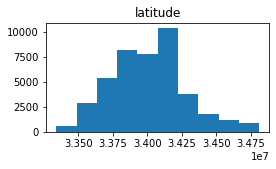

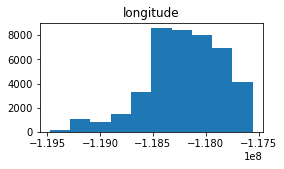

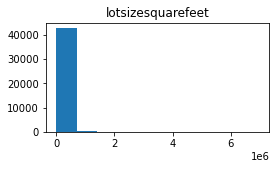

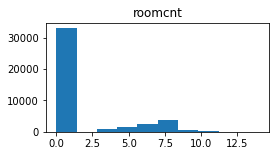

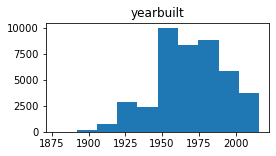

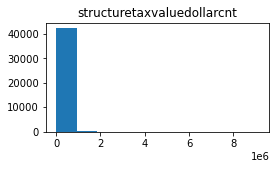

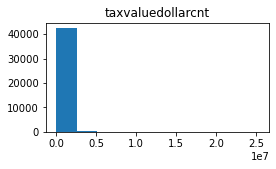

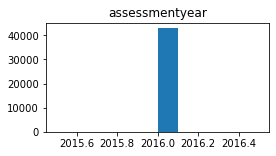

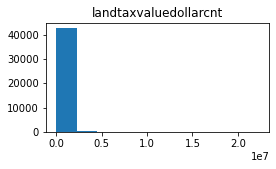

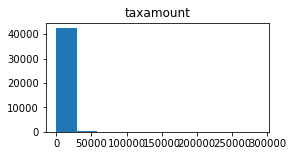

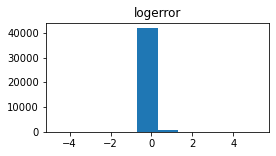

TypeError: '<=' not supported between instances of 'pandas._libs.interval.Interval' and 'float'

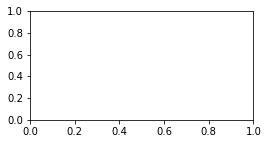

In [49]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

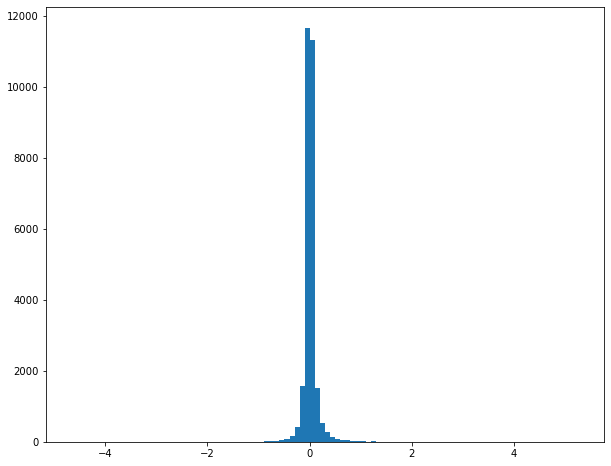

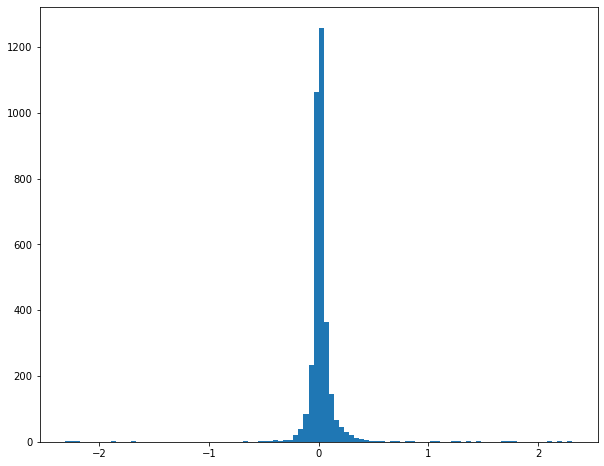

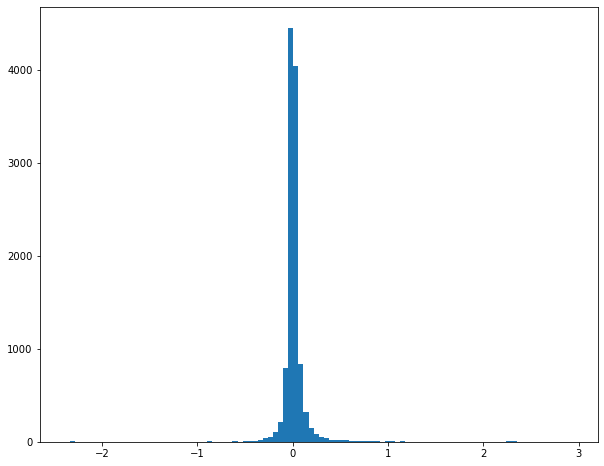

In [52]:
# Plot a histogram of logerror for each county.

for county in county_list:
    plt.figure(figsize=(10,8))
    plt.hist('logerror', bins=100, data=county)
    plt.show()

# Speaking of clusters...

In [219]:
X = X_train_scaled[['latitude','longitude','yearbuilt']]

In [221]:
# Create the KMeans object with three clusters.
kmeans = KMeans(n_clusters=3)

# Fit the KMeans object on the X values.
kmeans.fit(X)

# Use the KMeans object to predict the X_values and create a new column to store the values.
kmeans.predict(X)

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42963 entries, 45257 to 9184
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   bathroomcnt                   42963 non-null  float64 
 1   bedroomcnt                    42963 non-null  float64 
 2   calculatedfinishedsquarefeet  42963 non-null  float64 
 3   fips                          42963 non-null  float64 
 4   latitude                      42963 non-null  float64 
 5   longitude                     42963 non-null  float64 
 6   lotsizesquarefeet             42963 non-null  float64 
 7   roomcnt                       42963 non-null  float64 
 8   yearbuilt                     42963 non-null  float64 
 9   structuretaxvaluedollarcnt    42963 non-null  float64 
 10  taxvaluedollarcnt             42963 non-null  float64 
 11  assessmentyear                42963 non-null  float64 
 12  landtaxvaluedollarcnt         42963 non-nul

In [71]:
train['cluster'] = kmeans.predict(X)
X_train['cluster'] = kmeans.predict(X)
X_train_scaled['cluster'] = kmeans.predict(X)

In [72]:
kmeans.cluster_centers_

array([[0.28744544, 0.83104238, 0.75423686],
       [0.64009718, 0.48098763, 0.75382025],
       [0.45307374, 0.65905997, 0.48286898]])

In [73]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,latitude,longitude,yearbuilt
0,0.287445,0.831042,0.754237
1,0.640097,0.480988,0.753820
2,0.453074,0.659060,0.482869


In [144]:
X

,latitude,longitude,yearbuilt,cluster
45257,0.530507,0.655314,0.318841,1
54021,0.525921,0.655844,0.500000,1
71314,0.967247,0.625631,0.507246,3
8173,0.438309,0.601772,0.326087,1
20821,0.728139,0.476248,0.804348,3
...,...,...,...,...
1261,0.227100,0.858267,0.659420,0
15118,0.559994,0.516481,0.557971,1
54436,0.366778,0.773877,0.637681,0
19528,0.640076,0.467774,0.934783,3


Text(0.5, 1.0, 'Visualizing Cluster Centers')

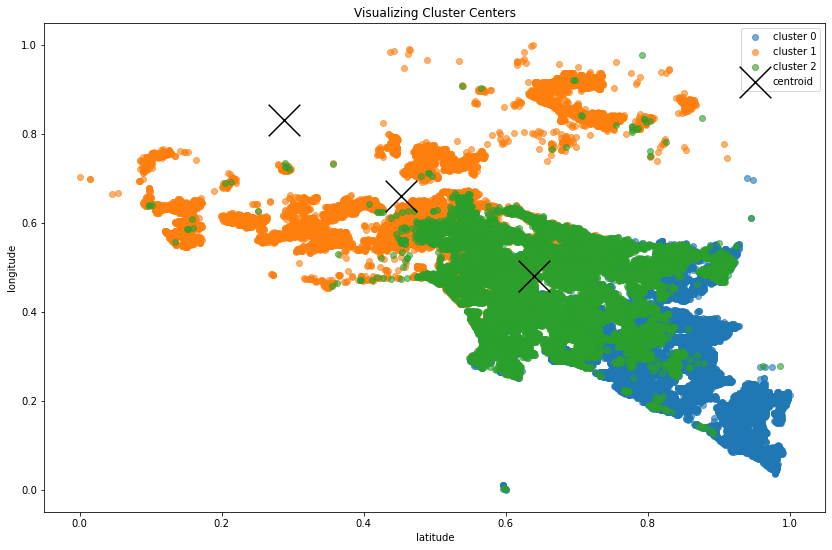

In [74]:
plt.figure(figsize=(14, 9))

for cluster, subset in X_train_scaled.groupby('cluster'):
    plt.scatter(subset.longitude, subset.latitude, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='longitude', x='latitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing Cluster Centers')

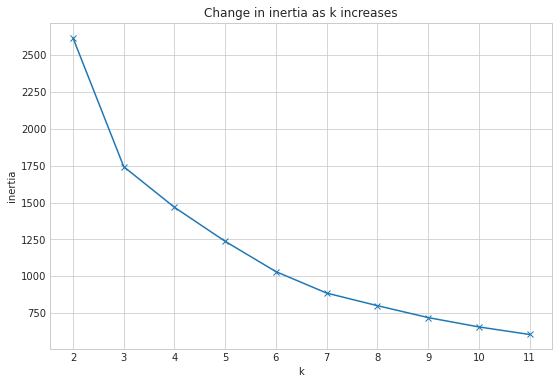

In [75]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [76]:
# Create the KMeans object with four clusters.
kmeans = KMeans(n_clusters=4)

# Fit the KMeans object on the X values.
kmeans.fit(X)

# Use the KMeans object to predict the X_values and create a new column to store the values.
kmeans.predict(X)

array([1, 1, 3, ..., 0, 3, 3], dtype=int32)

In [77]:
X_train['cluster'] = kmeans.predict(X)
X_train_scaled['cluster'] = kmeans.predict(X)

In [78]:
kmeans.cluster_centers_

array([[0.27690262, 0.83574806, 0.75097074],
       [0.45320859, 0.65817376, 0.48564972],
       [0.59720126, 0.3459628 , 0.70101391],
       [0.66675255, 0.61181031, 0.80616144]])

In [79]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,latitude,longitude,yearbuilt
0,0.276903,0.835748,0.750971
1,0.453209,0.658174,0.485650
2,0.597201,0.345963,0.701014
3,0.666753,0.611810,0.806161


Text(0.5, 1.0, 'Visualizing Cluster Centers')

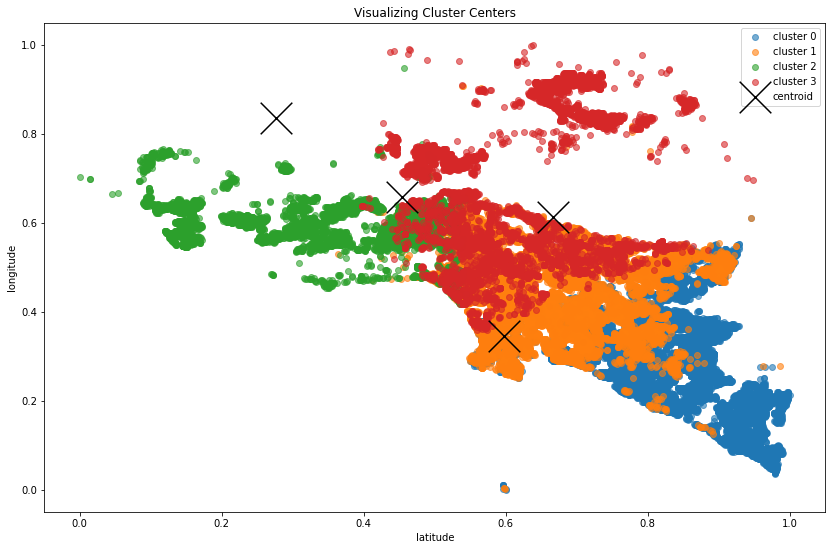

In [80]:
plt.figure(figsize=(14, 9))

for cluster, subset in X_train_scaled.groupby('cluster'):
    plt.scatter(subset.longitude, subset.latitude, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='longitude', x='latitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing Cluster Centers')

## Time to explore our clusters.

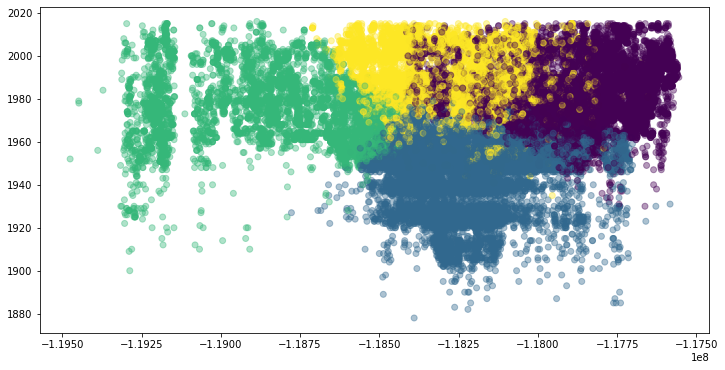

In [81]:
plt.figure(figsize=(12,6))
#plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.cluster, alpha=.4)
plt.scatter(y=X_train.yearbuilt, x=X_train.longitude, c=X_train.cluster, alpha=.4)

Text(0.5, 1.0, 'Do clusters reveal differences in age and error?')

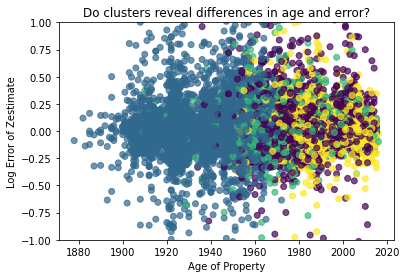

In [82]:
plt.scatter(y=y_train.logerror, x=X_train.yearbuilt, c=X_train.cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Age of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")

In [83]:
X_train.cluster.value_counts()

1    15467
0    13816
3     7548
2     6132
Name: cluster, dtype: int64

In [84]:
X['cluster'] = kmeans.predict(X)

In [85]:
train

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,...,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,logerror_bin,LA,Orange,Ventura,age_bins,cluster
45257,1.0,2.0,1148.0,6037.0,34119962.0,-118217185.0,6019.0,0.0,1922.0,110662.0,...,2016.0,442649.0,6724.25,-0.307749,"(-1.655, -0.155]",1,0,0,3,2
54021,2.0,2.0,898.0,6037.0,34113215.0,-118216168.0,6422.0,0.0,1947.0,150127.0,...,2016.0,450390.0,7192.46,-0.123643,"(-0.155, 1.345]",1,0,0,4,2
71314,1.0,1.0,1010.0,6037.0,34762455.0,-118274177.0,99411.0,0.0,1948.0,64420.0,...,2016.0,24359.0,4153.06,-0.002535,"(-0.155, 1.345]",1,0,0,5,1
8173,2.0,3.0,1218.0,6037.0,33984328.0,-118319988.0,4802.0,0.0,1923.0,66000.0,...,2016.0,268000.0,4062.89,-0.045101,"(-0.155, 1.345]",1,0,0,3,2
20821,1.0,1.0,835.0,6037.0,34410700.0,-118561000.0,842267.0,0.0,1989.0,141531.0,...,2016.0,70001.0,3470.57,0.014981,"(-0.155, 1.345]",1,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,2.0,3.0,1054.0,6059.0,33673616.0,-117827506.0,5100.0,5.0,1969.0,73538.0,...,2016.0,415232.0,5084.94,0.115894,"(-0.155, 1.345]",0,1,0,6,0
15118,3.0,4.0,2252.0,6037.0,34163340.0,-118483751.0,9179.0,0.0,1955.0,273029.0,...,2016.0,427049.0,8534.24,-0.146035,"(-0.155, 1.345]",1,0,0,5,2
54436,2.5,5.0,1992.0,6059.0,33879098.0,-117989539.0,2607.0,9.0,1966.0,50111.0,...,2016.0,21569.0,1054.76,0.014192,"(-0.155, 1.345]",0,1,0,6,0
19528,3.0,2.0,1253.0,6037.0,34281150.0,-118577269.0,49231.9,0.0,2007.0,343693.0,...,2016.0,148081.0,5945.66,-0.009137,"(-0.155, 1.345]",1,0,0,9,1


In [86]:
cluster_0 = train[train['cluster']==0]
cluster_1 = train[train['cluster']==1]
cluster_2 = train[train['cluster']==2]
cluster_3 = train[train['cluster']==3]

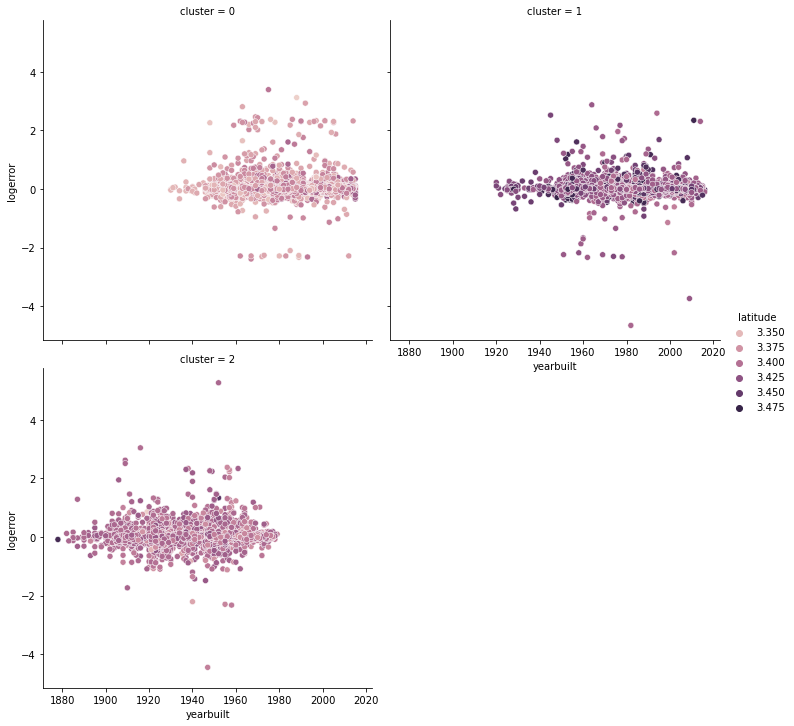

In [87]:
# plot out income vs. spending with regard to the cluster and age
sns.relplot(data=train, x="yearbuilt", y="logerror", col="cluster", hue="latitude", col_wrap=2)

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42963 entries, 45257 to 9184
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   bathroomcnt                   42963 non-null  float64 
 1   bedroomcnt                    42963 non-null  float64 
 2   calculatedfinishedsquarefeet  42963 non-null  float64 
 3   fips                          42963 non-null  float64 
 4   latitude                      42963 non-null  float64 
 5   longitude                     42963 non-null  float64 
 6   lotsizesquarefeet             42963 non-null  float64 
 7   roomcnt                       42963 non-null  float64 
 8   yearbuilt                     42963 non-null  float64 
 9   structuretaxvaluedollarcnt    42963 non-null  float64 
 10  taxvaluedollarcnt             42963 non-null  float64 
 11  assessmentyear                42963 non-null  float64 
 12  landtaxvaluedollarcnt         42963 non-nul

In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42963 entries, 45257 to 9184
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   42963 non-null  float64
 1   bedroomcnt                    42963 non-null  float64
 2   calculatedfinishedsquarefeet  42963 non-null  float64
 3   fips                          42963 non-null  float64
 4   latitude                      42963 non-null  float64
 5   longitude                     42963 non-null  float64
 6   lotsizesquarefeet             42963 non-null  float64
 7   roomcnt                       42963 non-null  float64
 8   yearbuilt                     42963 non-null  float64
 9   structuretaxvaluedollarcnt    42963 non-null  float64
 10  taxvaluedollarcnt             42963 non-null  float64
 11  assessmentyear                42963 non-null  float64
 12  landtaxvaluedollarcnt         42963 non-null  float64
 13

In [90]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42963 entries, 45257 to 9184
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   42963 non-null  float64
 1   bedroomcnt                    42963 non-null  float64
 2   calculatedfinishedsquarefeet  42963 non-null  float64
 3   fips                          42963 non-null  float64
 4   latitude                      42963 non-null  float64
 5   longitude                     42963 non-null  float64
 6   lotsizesquarefeet             42963 non-null  float64
 7   roomcnt                       42963 non-null  float64
 8   yearbuilt                     42963 non-null  float64
 9   structuretaxvaluedollarcnt    42963 non-null  float64
 10  taxvaluedollarcnt             42963 non-null  float64
 11  assessmentyear                42963 non-null  float64
 12  landtaxvaluedollarcnt         42963 non-null  float64
 13

In [91]:
X_train_scaled

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,age_bins,cluster
45257,0.000000,0.066667,0.045736,0.000000,0.530507,0.655314,0.000830,0.000000,0.318841,0.012060,0.021444,0.0,0.019766,0.023238,3,1
54021,0.083333,0.066667,0.034256,0.000000,0.525921,0.655844,0.000887,0.000000,0.500000,0.016366,0.023304,0.0,0.020112,0.024861,4,1
71314,0.000000,0.000000,0.039399,0.000000,0.967247,0.625631,0.014227,0.000000,0.507246,0.007015,0.003135,0.0,0.001037,0.014326,5,3
8173,0.083333,0.133333,0.048951,0.000000,0.438309,0.601772,0.000655,0.000000,0.326087,0.007187,0.012800,0.0,0.011946,0.014014,3,1
20821,0.000000,0.000000,0.031363,0.000000,0.728139,0.476248,0.120794,0.000000,0.804348,0.015429,0.007973,0.0,0.003081,0.011960,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,0.083333,0.133333,0.041420,0.297297,0.227100,0.858267,0.000698,0.357143,0.659420,0.008010,0.018900,0.0,0.018538,0.017556,6,0
15118,0.166667,0.200000,0.096432,0.000000,0.559994,0.516481,0.001283,0.000000,0.557971,0.029777,0.027228,0.0,0.019067,0.029512,5,1
54436,0.125000,0.266667,0.084493,0.297297,0.366778,0.773877,0.000340,0.642857,0.637681,0.005453,0.002461,0.0,0.000912,0.003587,6,0
19528,0.166667,0.066667,0.050558,0.000000,0.640076,0.467774,0.007029,0.000000,0.934783,0.037487,0.019018,0.0,0.006577,0.020539,9,3


In [105]:
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=16)

In [106]:
# Transform data using the rfe
X_rfe = rfe.fit_transform(X_train_scaled, y_train)

In [107]:
# Fitting the data to model
lm.fit(X_rfe, y_train)

LinearRegression()

In [108]:
mask = rfe.support_

In [109]:
rfe_features = X_train_scaled.loc[:, mask].columns.tolist()

In [110]:
rfe_features

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fips',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'roomcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'age_bins',
 'cluster']

In [111]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42963 entries, 45257 to 9184
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   bathroomcnt                   42963 non-null  float64 
 1   bedroomcnt                    42963 non-null  float64 
 2   calculatedfinishedsquarefeet  42963 non-null  float64 
 3   fips                          42963 non-null  float64 
 4   latitude                      42963 non-null  float64 
 5   longitude                     42963 non-null  float64 
 6   lotsizesquarefeet             42963 non-null  float64 
 7   roomcnt                       42963 non-null  float64 
 8   yearbuilt                     42963 non-null  float64 
 9   structuretaxvaluedollarcnt    42963 non-null  float64 
 10  taxvaluedollarcnt             42963 non-null  float64 
 11  assessmentyear                42963 non-null  float64 
 12  landtaxvaluedollarcnt         42963 non-nul

In [128]:
run_this_through_the_triplet_function = list(X_train_scaled.columns)

In [132]:
# Get every possible combination of a set of three features
list_of_feature_combinations = list(combinations(run_this_through_the_triplet_function,3))

In [215]:
# Fit this with clustering? I think that's the correct term. What is the length?
len(list_of_feature_combinations)

560

#### One way to choose the ideal number of clusters using inertia is the elbow method. To use the elbow method, we'll visualize the inertia against our choice in number of clusters. In this visualization, we'll look for the "elbow" of the curve, or the point where adding additional clusters doesn't give us as big of a reduction in inertia.

In [210]:
# I will convert all the tuples into lists and then to eventually Pandas dataframes.
# I'm not sure how long this will take. So I will test it on the first 10.
first_ten = list_of_feature_combinations[:10]

In [193]:
# Create a list of the first 10 features.
list_of_first_ten_features = []
for combo in first_ten:
    list_of_first_ten_features.append(list(combo))

In [211]:
list_of_first_ten_features

[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'],
 ['bathroomcnt', 'bedroomcnt', 'fips'],
 ['bathroomcnt', 'bedroomcnt', 'latitude'],
 ['bathroomcnt', 'bedroomcnt', 'longitude'],
 ['bathroomcnt', 'bedroomcnt', 'lotsizesquarefeet'],
 ['bathroomcnt', 'bedroomcnt', 'roomcnt'],
 ['bathroomcnt', 'bedroomcnt', 'yearbuilt'],
 ['bathroomcnt', 'bedroomcnt', 'structuretaxvaluedollarcnt'],
 ['bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt'],
 ['bathroomcnt', 'bedroomcnt', 'assessmentyear']]

In [212]:
list_of_dataframes = []
for combo in list_of_first_ten_features:
    list_of_dataframes.append(X_train[combo])

In [213]:
list_of_dataframes

[       bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet
 45257          1.0         2.0                        1148.0
 54021          2.0         2.0                         898.0
 71314          1.0         1.0                        1010.0
 8173           2.0         3.0                        1218.0
 20821          1.0         1.0                         835.0
 ...            ...         ...                           ...
 1261           2.0         3.0                        1054.0
 15118          3.0         4.0                        2252.0
 54436          2.5         5.0                        1992.0
 19528          3.0         2.0                        1253.0
 9184           3.0         2.0                        1377.0
 
 [42963 rows x 3 columns],
        bathroomcnt  bedroomcnt    fips
 45257          1.0         2.0  6037.0
 54021          2.0         2.0  6037.0
 71314          1.0         1.0  6037.0
 8173           2.0         3.0  6037.0
 20821          1.0        

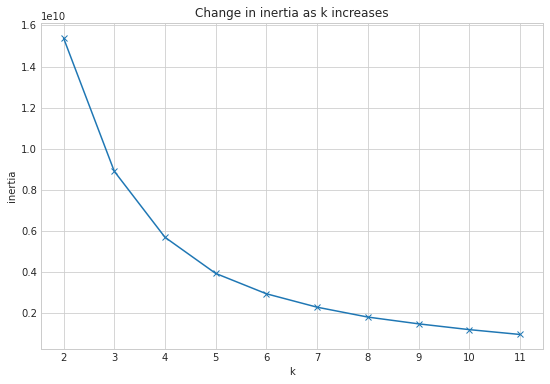

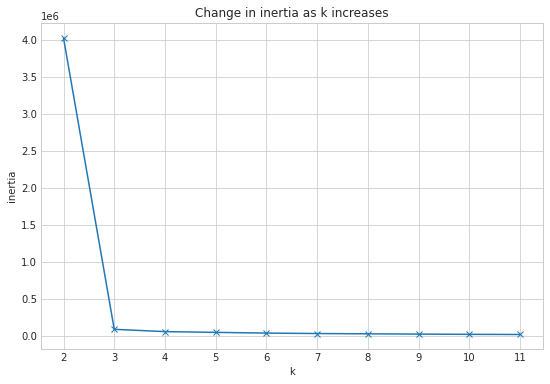

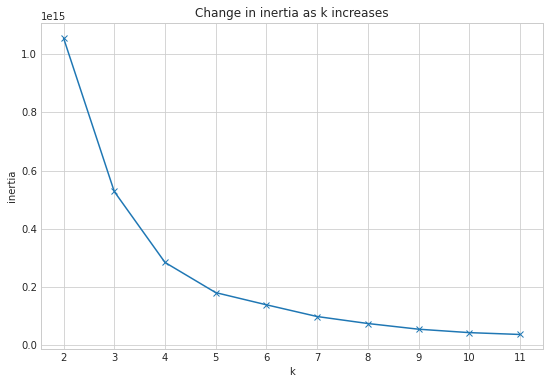

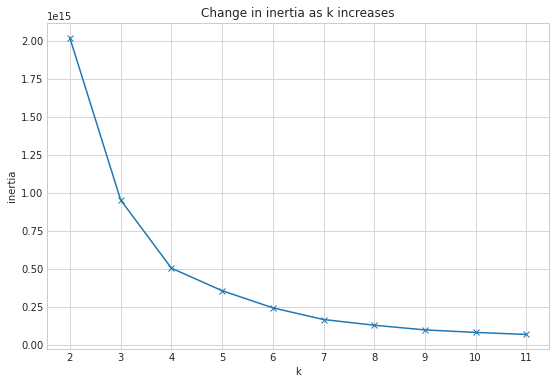

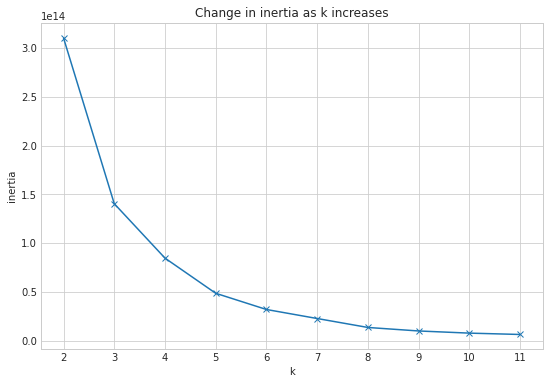

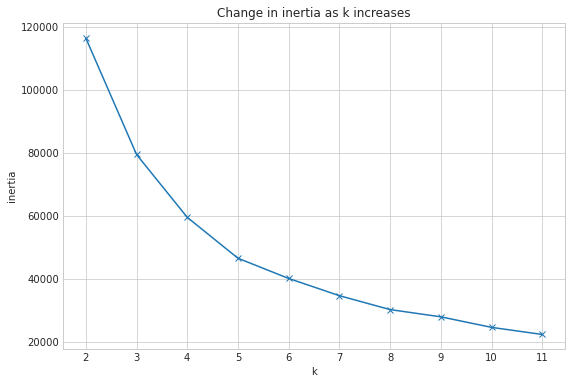

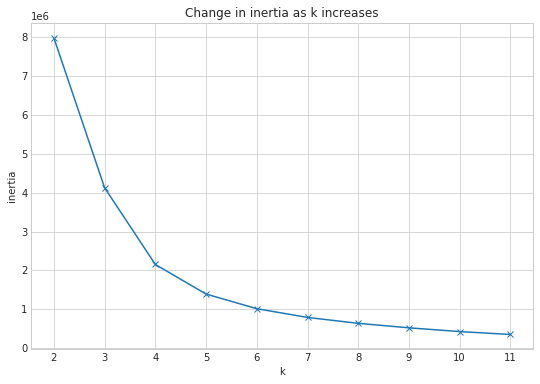

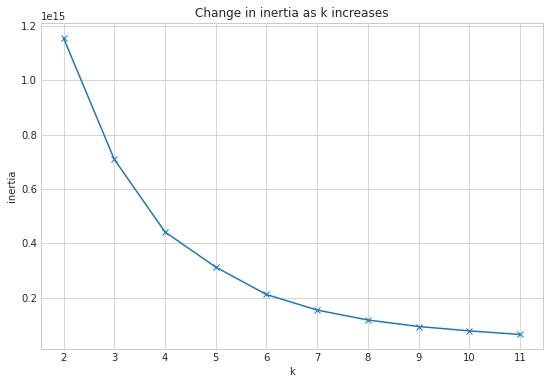

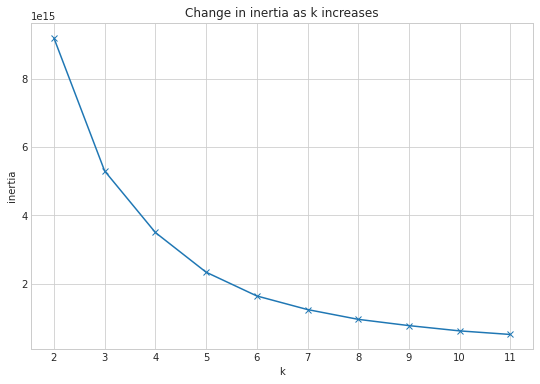

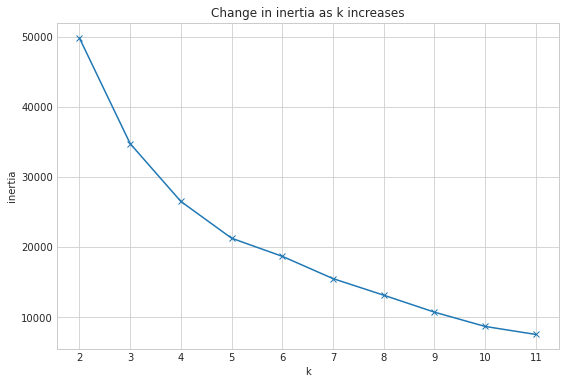

In [214]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

#### Determine k value for each group:
1: k = 5
2: k = 3
3: k = 5
4: k = 4
5: k = 4
6: k = 5
7: k = 4
8: k = 4
9: k = 4
10: k = 5

In [217]:
# Create a list for the k values to pass into a for loop.
number_of_centroids = [5,3,5,4,4,5,4,4,4,5]

In [216]:
*** list_of_dataframes ***

[       bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet
 45257          1.0         2.0                        1148.0
 54021          2.0         2.0                         898.0
 71314          1.0         1.0                        1010.0
 8173           2.0         3.0                        1218.0
 20821          1.0         1.0                         835.0
 ...            ...         ...                           ...
 1261           2.0         3.0                        1054.0
 15118          3.0         4.0                        2252.0
 54436          2.5         5.0                        1992.0
 19528          3.0         2.0                        1253.0
 9184           3.0         2.0                        1377.0
 
 [42963 rows x 3 columns],
        bathroomcnt  bedroomcnt    fips
 45257          1.0         2.0  6037.0
 54021          2.0         2.0  6037.0
 71314          1.0         1.0  6037.0
 8173           2.0         3.0  6037.0
 20821          1.0        

In [223]:
for combo in list_of_dataframes:
    for n in number_of_centroids:
        kmeans = KMeans(n)
        kmeans.fit(combo)
    kmeans.predict(combo)

In [ ]:


kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

I have a list of 560 combinations of features to cluster on. If I divide it into groups of 10 I will have 56 (560/10) lists of features to work on at a time as to not overload the computer. I will print the [{inertia vs k}] graph for each group of ten and choose a k value based on the graphs. After I have my k value for each group I will assign that to the number of centroids for each group.